## **USING MOBILENET FOR OUR MONKEY CLASSFIER**


Loading the MobileNet Model

In [ ]:
from tensorflow.keras.applications import MobileNet

# MobileNet was designed to work on 224x224pixel input img size
img_rows,img_cols = 224,224

# Re-loads the MobileNet Model without top/FC layers
MobileNet = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(img_rows,img_cols,3))

# Freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
  layer.trainable=False

# Printing the layers
for (i,layer) in enumerate(MobileNet.layers):
  print(str(i)+" "+layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 ReLU False
10 ZeroPadding2D False
11 DepthwiseConv2D False
12 BatchNormalization False
13 ReLU False
14 Conv2D False
15 BatchNormalization False
16 ReLU False
17 DepthwiseConv2D False
18 BatchNormalization False
19 ReLU False
20 Conv2D False
21 BatchNormalization False
22 ReLU False
23 ZeroPadding2D False
24 DepthwiseConv2D False
25 BatchNormalization False
26 ReLU False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 DepthwiseConv2D False
31 BatchNormalization False
32 ReLU False
33 Conv2D False
34 BatchNormalization False
35 ReLU False
36 ZeroPadding2D False
37 DepthwiseConv2D False
38 BatchNormalization False
39 ReLU False
40 Conv2D False
41 BatchNormalization False
42 ReLU False
43 DepthwiseConv2D False
44 BatchNormalization False
45 ReLU False
46 Conv2D False
47 BatchNormalization False
48

**Let's make a function that returns our FC Head**

In [ ]:
def addTopModelMobileNet(bottom_model,num_classes):
  # creates the top/head of the model that will be placed on top of the bottom layers
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(512,activation='relu')(top_model)
  top_model = Dense(num_classes,activation='softmax')(top_model) #for probability
  return top_model

**Let's add our FC Head back onto MobileNet**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import layer_normalization
from tensorflow.keras.models import Model

# Set our class number to 3(Young,Middle,Old)
num_classes = 10

# fully connected head = above model,10
FC_Head = addTopModelMobileNet(MobileNet,num_classes)

model = Model(inputs = MobileNet.input, outputs=FC_Head)

print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

!unzip drive/"My Drive"/archive.zip

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  drive/My Drive/archive.zip
replace monkey_labels.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace training/training/n0/n0018.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training/training/n0/n0018.jpg  
  inflating: training/training/n0/n0019.jpg  
  inflating: training/training/n0/n0020.jpg  
  inflating: training/training/n0/n0021.jpg  
  inflating: training/training/n0/n0022.jpg  
  inflating: training/training/n0/n0023.jpg  
  inflating: training/training/n0/n0024.jpg  
  inflating: training/training/n0/n0025.jpg  
  inflating: training/training/n0/n0026.jpg  
  inflating: training/training/n0/n0027.jpg  
  inflating: training/training/n0/n0028.jpg  
  inflating: training/training/n0/n0029.jpg  
  inflating: training/training/n0/n0030.jpg  
  inflating: training/training/n0/n0031.jpg  
  inflating: training/training/n0/n0032.j

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/training/training'
validation_data_dir = '/content/validation/validation'

# Using data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# set our batch size [typically on most mid-teir systems we use 16-32]
batch_size=32

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_rows,img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(img_rows,img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


**Training Our Model**


We're Using Checkpointing & Early Stopping

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/content/monkeymodel.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# We put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 1097
nb_validation_samples = 272

# We only train 5 EPOCHS 
epochs = 10
batch_size = 15

history = model.fit(
    train_generator,
    #steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
35/35 [==============================] - 94s 3s/step - loss: 0.8231 - accuracy: 0.8534 - val_loss: 0.2022 - val_accuracy: 0.9412

Epoch 00001: val_loss improved from inf to 0.20215, saving model to /content/monkeymodel.h5
Epoch 2/10
35/35 [==============================] - 73s 2s/step - loss: 0.1983 - accuracy: 0.9399
Epoch 3/10
35/35 [==============================] - 71s 2s/step - loss: 0.3156 - accuracy: 0.9217
Epoch 4/10
35/35 [==============================] - 72s 2s/step - loss: 0.2593 - accuracy: 0.9417
Epoch 5/10
35/35 [==============================] - 71s 2s/step - loss: 0.2857 - accuracy: 0.9253
Epoch 6/10
35/35 [==============================] - 71s 2s/step - loss: 0.1861 - accuracy: 0.9435
Epoch 7/10
35/35 [==============================] - 71s 2s/step - loss: 0.3202 - accuracy: 0.9335
Epoch 8/10
35/35 [==============================] - 71s 2s/step - loss: 0.2310 - accuracy: 0.9426
Epoch 9/10
35/35 [==============================] - 71s 2s/step - loss: 0.2530 - 

**Loading Our Classifier**

In [ ]:
from tensorflow.keras.models import load_model

classifier = load_model('/content/monkeymodel.h5')

**Testing our classifer on some test images**

Class - japanese_macaque


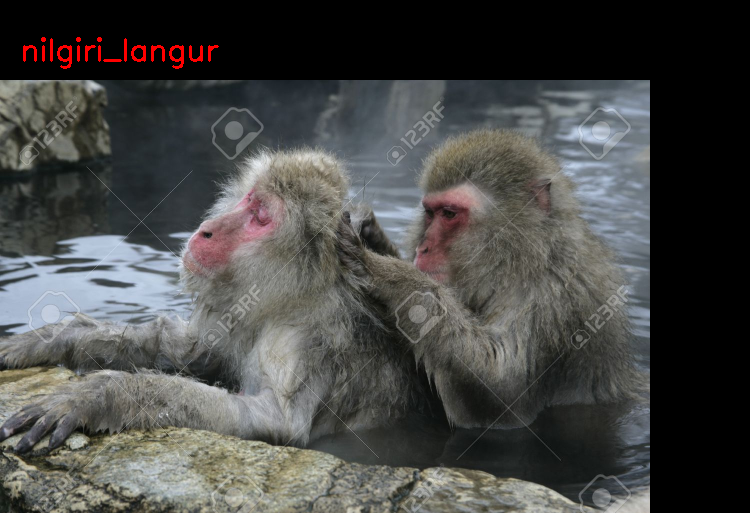

Class - japanese_macaque


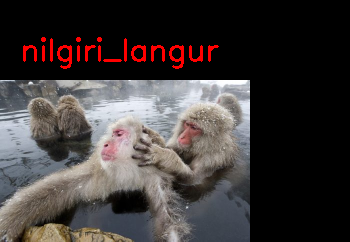

Class - pygmy_marmoset 


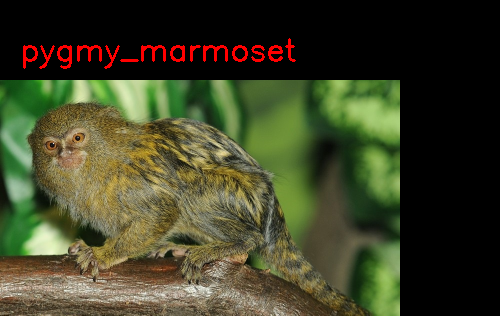

Class - white_headed_capuchin


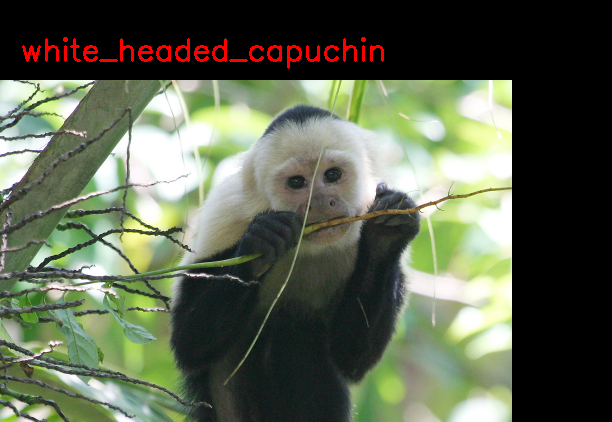

Class - japanese_macaque


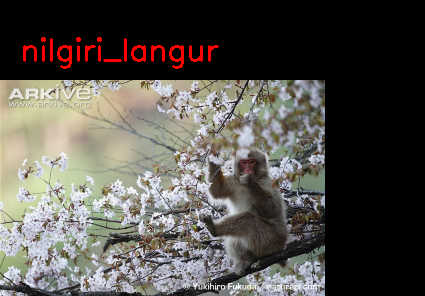

Class - mantled_howler 


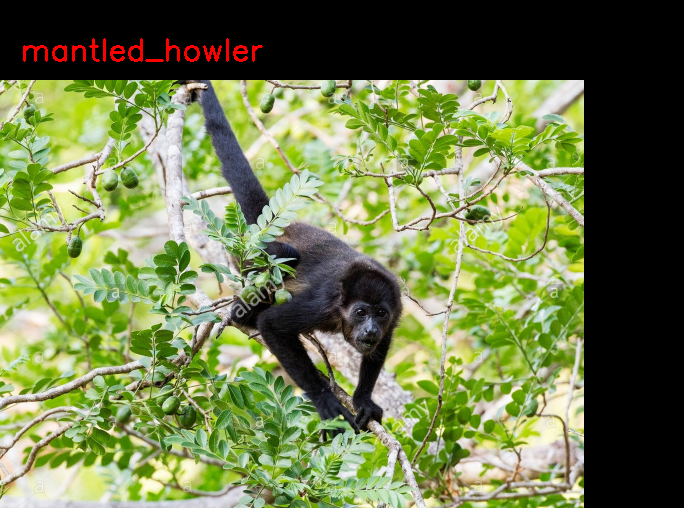

Class - common_squirrel_monkey


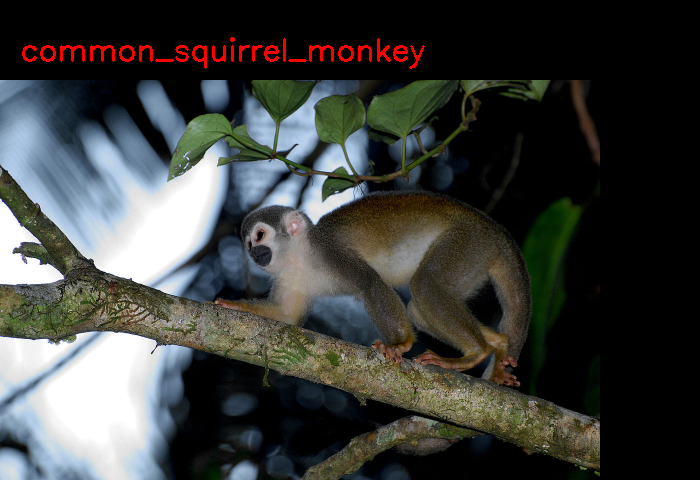

Class - common_squirrel_monkey


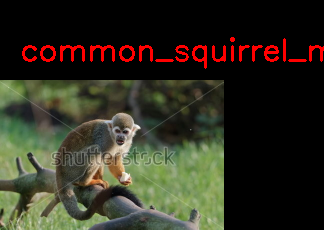

Class - silvery_marmoset


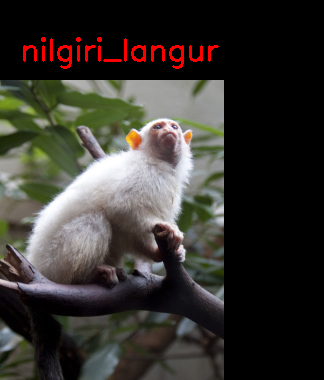

Class - patas_monkey


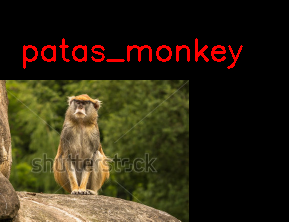

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from os import listdir
from os.path import isfile, join

monkey_breeds_dict = {"[0]": "mantled_howler ", 
                      "[1]": "patas_monkey",
                      "[2]": "bald_uakari",
                      "[3]": "japanese_macaque",
                      "[4]": "pygmy_marmoset ",
                      "[5]": "white_headed_capuchin",
                      "[6]": "silvery_marmoset",
                      "[7]": "common_squirrel_monkey",
                      "[8]": "black_headed_night_monkey",
                      "[9]": "nilgiri_langur"}

monkey_breeds_dict_n = {"n0": "mantled_howler ", 
                      "n1": "patas_monkey",
                      "n2": "bald_uakari",
                      "n3": "japanese_macaque",
                      "n4": "pygmy_marmoset ",
                      "n5": "white_headed_capuchin",
                      "n6": "silvery_marmoset",
                      "n7": "common_squirrel_monkey",
                      "n8": "black_headed_night_monkey",
                      "n9": "nilgiri_langur"}

def draw_test(name, pred, im):
    monkey = monkey_breeds_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv.putText(expanded_image, monkey, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2_imshow(expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + monkey_breeds_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name) 

for i in range(0,10):
    input_im = getRandomImage("/content/validation/validation/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

